In [1]:
import numpy as np
import dask.array as da

from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 7.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37185,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42073,Total threads: 4
Dashboard: http://127.0.0.1:44941/status,Memory: 1.51 GiB
Nanny: tcp://127.0.0.1:44067,


### 2. Dask Array 생성: numpy와 비슷하지만 'chunks'가 핵심
numpy 배열을 만들 때 shape을 지정했다면, dask.array는 shape과 함께 **chunks**를 지정해야 합니다.

- chunks란? dask.dataframe의 '파티션'과 동일한 개념입니다. 전체 배열을 잘게 쪼갠 numpy 배열 조각을 의미합니다.

예를 들어, (10000, 10000) 크기의 float64 배열을 numpy로 만들면 약 745MB의 RAM이 필요합니다. (200000, 200000) (약 298GB)처럼 메모리보다 큰 배열을 만들어 보겠습니다.

In [2]:
# (200000, 200000) 크기의 '계획' 생성
# 이 배열을 (5000, 5000) 크기의 '청크'로 쪼갠다.
# (총 40x40 = 1600개의 청크가 생성됨)
shape = (200_000, 200_000)
chunks = (5_000, 5_000)

# da.random.random()은 numpy와 동일하게 작동
# (실제 메모리 할당 안 함. 0.1초 미만 소요)
dask_arr = da.random.random(shape, chunks=chunks)

print(dask_arr)

dask.array<random_sample, shape=(200000, 200000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>


### 3. 연산: 지연 평가(lazy)와 .compute()

계획 객체: dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0834783 to fit


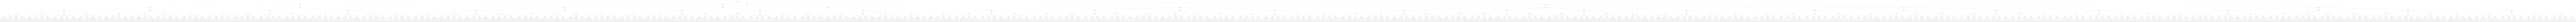

In [3]:
# 1. 298GB짜리 배열의 '평균'을 구하는 '계획'
mean_plan = dask_arr.mean()

print(f"계획 객체: {mean_plan}")

# 2. .visualize()로 태스크 그래프 확인
mean_plan.visualize()

In [4]:
%%time
# 3. .compute()로 실제 연산 실행
# ❗️ 대시보드 관찰:
# 1600개의 'random' 작업이 병렬로 실행되고,
# 워커 메모리가 (5천,5천) 청크 크기만큼만 올랐다가 비워지는 것을 반복합니다.
# (298GB가 한 번에 올라가지 않음!)
mean_val = mean_plan.compute()

print(f"\n배열의 평균값: {mean_val}")


배열의 평균값: 0.4999974451359227
CPU times: user 59.8 s, sys: 6.8 s, total: 1min 6s
Wall time: 1min 28s


### 4. 청크와 연산의 관계

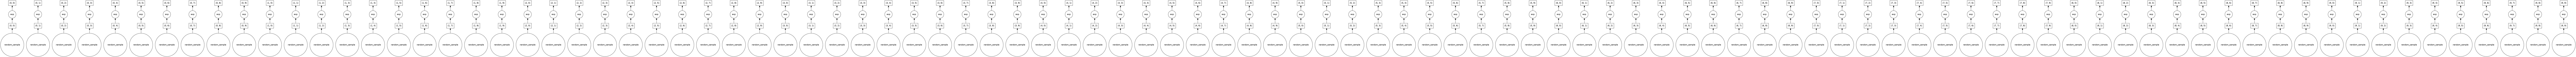

In [5]:
# (10000, 10000) 크기, (1000, 1000) 청크 -> 100개 청크
x = da.random.random((10000, 10000), chunks=(1000, 1000))
y = da.exp(x)  # 100개의 청크에 대해 각각 np.exp()를 실행하면 됨

y.visualize()  # 매우 단순한 1:1 그래프

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.34716 to fit


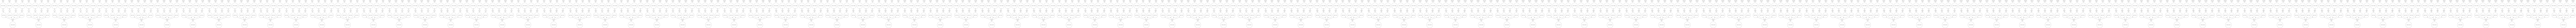

In [6]:
# (1000, 1000) -> (500, 500)으로 재조정 '계획'
# rechunk는 꼭 필요할 때만 써야하는 비싼 연산.
y = x.rechunk(chunks=(500, 500))

y.visualize()  # 100개 -> 400개로 쪼개는 복잡한 셔플 그래프

### 5. dask.bag: 비정형 데이터를 위한 솔루션

In [7]:
import dask.bag as db
import os

data_dir = "./dask_data"

# 1GB짜리 JSON 로그 파일 10개를 읽는다고 '가정' (파일 10개 = 10 파티션)
# (실제로는 dask_data의 CSV를 읽어보겠습니다)
log_files = os.path.join(data_dir, "*.csv")
log_bag = db.read_text(log_files)  # 파일 내용을 '줄(line)' 단위로 읽음

# .map()으로 각 줄(str)을 'A'가 포함되었는지(bool)로 변환
# .filter(lambda x: x is True)로 필터링
# .count()로 최종 개수 집계
a_lines_count = (
    log_bag.map(lambda line: "A" in line).filter(lambda x: x is True).count()
)

# .compute() 실행 (대시보드에서 3개 파일 병렬로 읽음)
print(a_lines_count.compute())

999999
